In [ ]:
from google.colab import drive, files
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip3 install transformers
!cp /content/drive/MyDrive/fake-news-explainability/utils_fake_news.py .

     |████████████████████████████████| 3.1 MB 5.3 MB/s 
     |████████████████████████████████| 3.3 MB 19.7 MB/s 
     |████████████████████████████████| 895 kB 25.8 MB/s 
     |████████████████████████████████| 59 kB 6.3 MB/s 
     |████████████████████████████████| 596 kB 36.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pandas as pd
import numpy as np
import json, re
from tqdm import tqdm_notebook
from uuid import uuid4
import time
import datetime
import random
import itertools
import os

## Torch Modules
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import (
    Dataset, 
    DataLoader,
    TensorDataset, 
    random_split, 
    RandomSampler, 
    SequentialSampler)

# Transformers
from transformers import (
    BertModel,
    BertForSequenceClassification,
    BertTokenizer,
    RobertaForSequenceClassification,
    RobertaTokenizer,
    AdamW,
    get_linear_schedule_with_warmup)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

%run utils_fake_news.py

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

## Model & Training Function

In [ ]:
def train():
    total_t0 = time.time()
    for epoch_i in range(0, epochs):
        
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        t0 = time.time()
        total_train_loss = 0
        bert_model.train()

        for step, batch in enumerate(bert_train_dataloader):

            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                elapsed = format_time(time.time() - t0)
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(bert_train_dataloader), elapsed))

            # Unpack batch
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Zero grads
            bert_model.zero_grad()        

            # Forward pass
            output = bert_model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask, 
                                labels=b_labels)
            # Accumulate loss
            total_train_loss += output[0].item()

            # Backward pass
            output[0].backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(bert_model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The bert_optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            bert_optimizer.step()

            # Update the learning rate.
            bert_scheduler.step()

        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(bert_train_dataloader)            
        
        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epoch took: {:}".format(training_time))
        
        # Record all statistics from this epoch.
        bert_training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Training Time': training_time,
            }
        )

    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

## Load Data

In [ ]:
# Run if the data has already been encoded
# Load encoded Fake-News dataset
df_train_encode = torch.load("/content/drive/MyDrive/fake-news-explainability/Data/Encoded/fake_news/training/fake_news.pt")

# Split into train and test
train, test = torch.utils.data.random_split(df_train_encode, [14169, 6073])
torch.save(train, '/content/drive/MyDrive/fake-news-explainability/Data/Encoded/fake_news/training/fake_news_train.pt')
torch.save(test, '/content/drive/MyDrive/fake-news-explainability/Data/Encoded/fake_news/training/fake_news_test.pt')

# Load data into dataloader
batch_size = 32
bert_train_dataloader = DataLoader(
            train,  # The training samples.
            batch_size = batch_size # Trains with this batch size.
)

## Training

In [ ]:
# Device
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device("cpu")

# BERT
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Model
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                           num_labels = 2,
                                                           output_attentions = False,
                                                           output_hidden_states = False
                                                          ).to(device)

# Optimizer
bert_optimizer = AdamW(bert_model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
# Training Params
bert_training_stats = []
epochs = 10
total_steps = len(bert_train_dataloader) * epochs

# Learning rate scheduler
bert_scheduler = get_linear_schedule_with_warmup(bert_optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
# Train or load pre-trained
bert_model_path = "/content/drive/MyDrive/fake-news-explainability/Models/fn_model"
    
if os.path.exists(bert_model_path):
    bert_model = BertForSequenceClassification.from_pretrained(
        bert_model_path, num_labels = 2).to(device)
else:
    train()
    bert_model.save_pretrained(bert_model_path)

## Accuracy

In [ ]:
import itertools
def evaluate(bert_dataloader, bert_model):
    # Generate predictions
    outputs = []
    labels = []
    with torch.no_grad():
        for step, batch in enumerate(bert_dataloader):
            # Unpack batch
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            
            # Forward pass
            output = bert_model(b_input_ids, b_input_mask)
            outputs.append(output)   

            # Keep labels
            labels.append(b_labels)     
            
    # Stack outputs
    outputs = torch.vstack([item[0].detach() for item in outputs])

    # Stack labels
    labs = [list(i.cpu().numpy()) for i in labels]
    labs = np.array(list(itertools.chain(*labs)))

    return outputs, labs

In [ ]:
# Load test dataset into dataloader
batch_size = 32
bert_dataloader = DataLoader(test, batch_size = batch_size)

# Evaluate
outputs, labs = evaluate(bert_dataloader, bert_model)

# Accuracy
print(f"Accuracy: {flat_accuracy(outputs.detach().cpu().numpy(), labs)}")

## Evaluate

In [ ]:
# Load encoded tensors
# df_pos_encode = torch.load("/content/drive/MyDrive/fake-news-explainability/Data/Encoded/fake_news/evaluation/fake_news_pos.pt")
# df_neg_encode = torch.load("/content/drive/MyDrive/fake-news-explainability/Data/Encoded/fake_news/evaluation/fake_news_neg.pt")

df_pos_encode = torch.load("/content/drive/MyDrive/fake-news-explainability/Data/Encoded/fake_news/evaluation/fake_news_name_orig_filtered.pt")
df_neg_encode = torch.load("/content/drive/MyDrive/fake-news-explainability/Data/Encoded/fake_news/evaluation/fake_news_name_new_filtered.pt")

# df_pos_encode = torch.load("/content/drive/MyDrive/fake-news-explainability/Data/Encoded/fake_news/evaluation/fake_news_polarity_orig_filtered.pt")
# df_neg_encode = torch.load("/content/drive/MyDrive/fake-news-explainability/Data/Encoded/fake_news/evaluation/fake_news_polarity_new_filtered.pt")

In [ ]:
# Load test dataset into dataloader
bert_dataloader_pos = DataLoader(df_pos_encode, batch_size = 32)
bert_dataloader_neg = DataLoader(df_neg_encode, batch_size = 32)

outputs_pos, labs = evaluate(bert_dataloader_pos, bert_model)
outputs_neg, labs = evaluate(bert_dataloader_neg, bert_model)

## Metrics

In [ ]:
# Percent Labels Flipped
cf_matrix = confusion_matrix(np.argmax(outputs_pos.cpu(), axis=1), 
                             np.argmax(outputs_neg.cpu(), axis=1))
try:
  print(f"{cf_matrix[0,1]+cf_matrix[1,0]}/{np.sum(cf_matrix)} ({round(100*(cf_matrix[0,1]+cf_matrix[1,0])/np.sum(cf_matrix),4)}%)")
except:
  print(f"0/{np.sum(cf_matrix)} (0.0%)")

# Average Probability Change
m = nn.Softmax(dim=1)
delta_lst = m(outputs_neg)[:,1]-m(outputs_pos)[:,1]
print(f"{round(float(torch.mean(delta_lst)),4)}")

1/108 (0.9259%)
-0.0077


## Explainability Methods

In [ ]:
def _register_embedding_list_hook(model, embeddings_list):
    def forward_hook(module, inputs, output):
        embeddings_list.append(output.squeeze(0).clone().cpu().detach().numpy())
    embedding_layer = model.bert.embeddings.word_embeddings
    handle = embedding_layer.register_forward_hook(forward_hook)
    return handle

def _register_embedding_gradient_hooks(model, embeddings_gradients):
    def hook_layers(module, grad_in, grad_out):
        embeddings_gradients.append(grad_out[0])
    embedding_layer = model.bert.embeddings.word_embeddings
    hook = embedding_layer.register_backward_hook(hook_layers)
    return hook

def saliency_map(model, input_ids, input_mask):
    torch.enable_grad()
    model.eval()
    embeddings_list = []
    handle = _register_embedding_list_hook(model, embeddings_list)
    embeddings_gradients = []
    hook = _register_embedding_gradient_hooks(model, embeddings_gradients)

    model.zero_grad()
    A = model(input_ids, input_mask)
    # pred_label_ids = np.argmax(A.logits[0].detach().cpu().numpy())
    A.logits[0][1].backward()
    handle.remove()
    hook.remove()

    saliency_grad = embeddings_gradients[0].detach().cpu().numpy()        
    saliency_grad = np.sum(saliency_grad[0] * embeddings_list[0], axis=1)
    norm = np.linalg.norm(saliency_grad, ord=1)
    saliency_grad = [e / norm for e in saliency_grad] 
    
    return saliency_grad

In [ ]:
import matplotlib.pyplot as plt
import string
import textwrap
plt.rcParams.update({'font.size': 48})
        
def as_pyplot_figure(scores_lst, title=''):
    """Returns the explanation as a pyplot figure.
    Will throw an error if you don't have matplotlib installed
    Args:
        label: desired label. If you ask for a label for which an
                explanation wasn't computed, will throw an exception.
                Will be ignored for regression explanations.
        kwargs: keyword arguments, passed to domain_mapper
    Returns:
        pyplot figure (barchart).
    """
    vals = [i[0] for i in scores_lst][::-1]
    names = [i[1] for i in scores_lst][::-1]
    fig = plt.figure()
    colors = ['orange' if x > 0 else 'blue' for x in vals]
    pos = np.arange(len(vals)) + .5
    plt.barh(pos, vals, align='center', color=colors)
    plt.yticks(pos, names)
    main_title = title if title else 'Local Explanation'
    plt.title(main_title)
    plt.xlabel('GxI Score')

In [ ]:
# Encode sentences
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def encode_sent(sent):
  return bert_tokenizer.encode_plus(sent,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 120,           # Pad & truncate all sentences.
                          pad_to_max_length = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                          truncation = True)
  
def explain(sent, model=bert_model, tokenizer=bert_tokenizer, plot=False, limit=100):
  sent_d = encode_sent(sent)
  scores = saliency_map(model, sent_d['input_ids'].to(device), sent_d['attention_mask'].to(device))
  tokens = [tokenizer.decode([i]) for i in sent_d['input_ids'][0]]
  ig_scores = [(v,w) for (v,w) in zip(scores,tokens) if (abs(v)>0)&\
                                                        (w not in ['[SEP]','[PAD]','[CLS]'])&\
                                                        (w not in string.punctuation)]
  # ig_scores = sorted(ig_scores, key=lambda item: -abs(item[0]))
  
  if plot:
    as_pyplot_figure(ig_scores[:limit], title='\n'.join(textwrap.wrap(sent.capitalize(), 50)))
  else:
    return ig_scores


In [ ]:
# Read in sentences from Fake-News dataset
myfile = open("fake_news.txt", "r")
myline = myfile.readline()
corpus = []
while myline:
    corpus.append(myline)
    myline = myfile.readline()
myfile.close()   

In [ ]:
# Generate explanations for all sentences
explain_lst = [explain(c) for c in corpus]
explain_lst = [{word:val for (val,word) in item} for item in explain_lst]

# Generate scores for all words
vocab_scores = {}
for d in explain_lst:
  for key in d:
    if key in vocab_scores:
      vocab_scores[key].append(d[key])
    else:
      vocab_scores[key] = [d[key]]

In [ ]:
np.mean(vocab_scores['hillary'])

-0.0463415

In [ ]:
np.mean(vocab_scores['trump'])

0.008754054

In [ ]:
np.mean(vocab_scores['obama'])

-0.013028966

In [ ]:
sorted(vocab_mean, key=lambda i: -abs(i[1]))[:30]

[('”', 0.45140153, 1),
 ('attorneys', 0.43750408, 1),
 ('bloomberg', 0.36911598, 1),
 ('sanford', 0.29711664, 1),
 ('##mc', 0.2649178, 1),
 ('berkeley', 0.26305962, 2),
 ('hollywood', -0.25957772, 1),
 ('##ago', 0.2579535, 1),
 ('rub', 0.24989688, 1),
 ('##ulia', 0.24410377, 1),
 ('lew', 0.2327223, 1),
 ('complicated', 0.22688188, 1),
 ('munich', 0.22126403, 1),
 ('kai', -0.22038929, 1),
 ('hai', -0.19809927, 1),
 ('siren', 0.19610888, 1),
 ('qatar', -0.19401038, 1),
 ('jody', 0.19393232, 1),
 ('error', -0.19305873, 1),
 ('terror', 0.19272181, 1),
 ('##ree', -0.18873553, 2),
 ('drag', -0.1875716, 1),
 ('milo', 0.1857708, 1),
 ('bunker', -0.18072022, 1),
 ('cancel', 0.18014425, 1),
 ('intel', -0.17358446, 1),
 ('candidate', 0.1734103, 1),
 ('marco', 0.1716335, 1),
 ('gore', 0.16768375, 2),
 ('wellesley', 0.16628824, 1)]

In [ ]:
# Find the average Gradient x Input score per word and the number of occurrences
vocab_mean = [(key,np.mean(vocab_scores[key]),len(vocab_scores[key])) for key in vocab_scores.keys()]

In [ ]:
import seaborn as sns
sns.set(rc = {'figure.figsize':(5,2.5)})

sns.scatterplot(x = [i[2] for i in vocab_mean],
                y = [i[1] for i in vocab_mean])
plt.xlabel('Frequency (# Documents)')
plt.ylabel('Mean Gradient \n x Input Score')

### GxI Explanations

In [ ]:
sns.set(rc = {'figure.figsize':(7.5,6)})

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


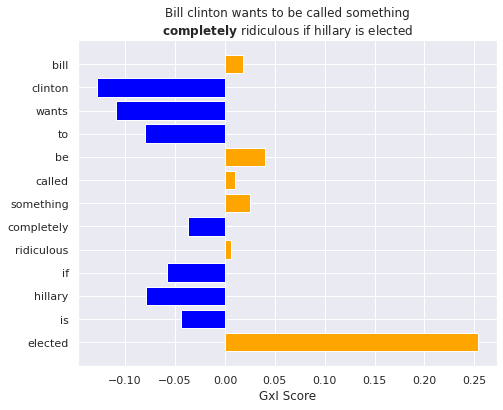

In [ ]:
ig_scores1 = explain("Bill Clinton wants to be called something completely ridiculous if Hillary is elected")
sent = r"Bill Clinton wants to be called something $\bf{completely}$ ridiculous if Hillary is elected"
as_pyplot_figure(ig_scores1, title='\n'.join(textwrap.wrap(sent.capitalize(), 50)))

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


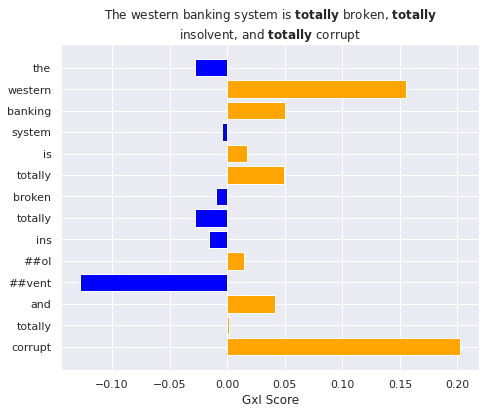

In [ ]:
ig_scores2 = explain("The western banking system is totally broken, totally insolvent, and totally corrupt")
sent = r"The western banking system is $\bf{totally}$ broken, $\bf{totally}$ insolvent, and $\bf{totally}$ corrupt"
as_pyplot_figure(ig_scores2, title='\n'.join(textwrap.wrap(sent.capitalize(), 75)))
